In [1]:
# Name: example_density_analysis.ipynb
# Authors: Stephan Meighen-Berger
# Example simulation runs to check the number of flashes vs organism density
# This includes an example how to construct a custom detector

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import pickle
from matplotlib.lines import Line2D

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [5]:
# picture path
PICS = '../pics/'

In [6]:
# Module imports
from fourth_day import Fourth_Day, config

In [7]:
# Density function
# Converts a given density organisms/m^3 to something usable by Fourth Day
def dens2fd(density, ylength, current_velocity):
    # Injection density
    injection_volume_per_time_step = ylength * current_velocity
    org_per_time_step = injection_volume_per_time_step * density
    return org_per_time_step

In [8]:
# Scenario Settings
# These are general settings pertaining to the simulation run
config['scenario']['population size'] = 10  # The starting population size
config['scenario']['exclusion'] = True  # If an exclusion zone should be used (the detector)
config['scenario']['injection']['rate'] = 1e-2  #  Injection rate in per second, a distribution is constructed from this value
config['scenario']['injection']['y range'] = [0.5 * 15. - 0.15 - 2.5, 0.5 * 15. - 0.15 + 2.5]  # The y-range of injection
config['scenario']['light prop'] = {  # Where the emitted light should be propagated to (typically the detector location)
            "switch": False,  # If light should be propagated
            "x_pos": 3.,  # The x-coordinates
            "y_pos": 0.5 * 15. - 0.15,  # The y-coordinates
        }
config['scenario']['detector'] = {  # detector specific properties, positions are defined as offsets from the light prop values
    "switch": False,  # If the detector should be modelled
    "type": "PMTSpec",  # Detector name, implemented types are given in the config
    "response": True,  # If a detector response should be used
    "acceptance": "Flat",  # Flat acceptance
    "mean detection prob": 0.5  # Used for the acceptance calculation
}
# ---------------------------------------------
# Organisms
# Organisms properties are defined here
config['organisms']['emission fraction'] = 0.2  # Amount of energy an organism uses per pulse
config['organisms']['alpha'] = 1e1  # Proportionality factor for the emission probability
config['organisms']["minimal shear stress"] = 0.05  # The minimal amount of shear stress needed to emit (generic units)
config["organisms"]["filter"] = 'depth'  # Method of filtering organisms (here depth)
config["organisms"]["depth filter"] = 1000.  # Organisms need to exist below this depth
# ---------------------------------------------
# Geometry
# These settings define the geometry of the system
# Typically a box (simulation volume) with a spherical exclusion zone (detector)
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 30.,
    'y_length': 15.,
    'offset': None,
}
# Reduce the observation size to reduce the computational load
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 30.,
    'y_length': 15.,
    "offset": np.array([0., 0.]),
}
# The detector volume
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 3.,
    "y_pos": 0.5 * 15. - 0.15,
}
# ---------------------------------------------
# Water
# Properties of the current model
config['water']['model']['name'] = 'custom'  # Use a custom (non analytic) model
config['water']['model']['off set'] = np.array([0., 0.])  # Offset of the custom model

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48, 17.82]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48, 17.82, 29.5]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48, 17.82, 29.5, 47.54]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48, 17.82, 29.5, 47.54, 80.42]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48, 17.82, 29.5, 47.54, 80.42, 131.94]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48, 17.82, 29.5, 47.54, 80.42, 131.94, 217.2]


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:20:12<00:00, 96.26s/it]


[0.02, 0.02, 0.02, 0.42, 1.66, 2.74, 5.88, 10.48, 17.82, 29.5, 47.54, 80.42, 131.94, 217.2, 356.94]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


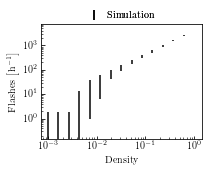

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5, 23.58]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5, 23.58, 39.34]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5, 23.58, 39.34, 64.06]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5, 23.58, 39.34, 64.06, 107.92]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5, 23.58, 39.34, 64.06, 107.92, 180.1]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5, 23.58, 39.34, 64.06, 107.92, 180.1, 292.56]


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:59:17<00:00, 143.15s/it]


[0.0, 0.0, 0.0, 0.86, 1.98, 3.72, 7.28, 14.5, 23.58, 39.34, 64.06, 107.92, 180.1, 292.56, 484.24]


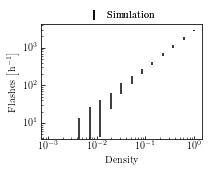

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78, 22.44]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78, 22.44, 35.58]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78, 22.44, 35.58, 58.64]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78, 22.44, 35.58, 58.64, 101.42]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78, 22.44, 35.58, 58.64, 101.42, 161.84]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78, 22.44, 35.58, 58.64, 101.42, 161.84, 263.72]


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [4:41:57<00:00, 338.34s/it]


[0.02, 0.02, 0.02, 0.86, 1.86, 3.28, 6.7, 13.78, 22.44, 35.58, 58.64, 101.42, 161.84, 263.72, 437.28]


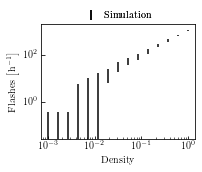

In [9]:
# Launching multiple simulations to use in the analysis
seeds = range(50)
densities = np.logspace(-3., 0., 15)
water_models = [
    ["run_10cm_npy/", 0.1, 1, r'$10\;\mathrm{cm/s}$', '10cm', 12.],
    ["run_5cm_npy/", 0.05, 2, r'$5\;\mathrm{cm/s}$', '5cm', 6.],
    ["run_2cm_npy/", 0.02, 5, r'$2\;\mathrm{cm/s}$', '2cm', 2.4]
    ]
for model in water_models:
    flash_vs_dens = []
    flash_vs_dens_std = []
    for density in densities:
        inject_org = dens2fd(density, 5., model[1])
        peak_arr = []
        for seed in tqdm(seeds):
            # General
            config["general"]["random state seed"] = seed
            config['scenario']['population size'] = 10
            config['scenario']['injection']['rate'] = inject_org
            config['scenario']['duration'] = 600 * model[2]  # Total simulation time in seconds
            config["scenario"]["statistics storage"]["name"] = "dens_run_dens_2cm_%.1e_seed_%d" %(density, seed)
            config['water']['model']['directory'] = "../data/current/Parabola_5mm/" + model[0]  # The files used by the custom model
            config['water']['model']['time step'] = model[2]  # in Seconds
            # Creating a fourth_day object
            fd = Fourth_Day()
            # Launching solver
            fd.sim()
            # Skipping the warm-up phase
            total_flashes = 0.
            # Skipping the first cycle
            warm_up = int(600 * model[2] / 2)
            for stat in fd.statistics[warm_up:]:
                total_flashes += np.sum(stat["pulse start"])
            peak_arr.append(total_flashes)
        peak_arr = np.array(peak_arr)
        flash_vs_dens.append(np.mean(peak_arr))
        flash_vs_dens_std.append(np.std(peak_arr))
    flash_vs_dens = np.array(flash_vs_dens)
    flash_vs_dens_std = np.array(flash_vs_dens_std)
    # ---------------------------------------------------------------------------------------------------
    # Plotting
    plot_data = np.copy(flash_vs_dens)
    scaling = model[5]  # Conversion to per hour
    plot_data = plot_data * scaling  # Average per hour
    # z1 = np.polyfit(densities, plot_data, 1, w=1./flash_vs_dens_std)
    # z = np.polyfit(densities, plot_data, 2, w=1./flash_vs_dens_std)
    # p1 = np.poly1d(z1)
    # p = np.poly1d(z)
    # Plotting standards
    std_size = 3.
    fontsize = 10.
    lw=1.
    h_length=1.
    # Plot figure with subplots of different sizes
    fig, ax1 = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
    # ---------------------------------------------------------------------------------------------------
    # Plot parameters
    ylow = 1e-3
    yhigh = 0.2
    # xlow = 0
    # xhigh = 10
    # ---------------------------------------------------------------------------------------------------
    # The average emissions
    ax1.errorbar(
        densities,
        plot_data,
        yerr= flash_vs_dens_std * scaling,
        linestyle="None", color='k', label=r'$\mathrm{Simulation}$')
    # ax1.plot(np.logspace(-4, 0, 100), p1(np.logspace(-4, 0, 100)), 'r', lw=lw, ls='--', label=r'$\mathrm{Linear}$')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
    ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
    # ax1.set_xlim(ylow, yhigh)
    # ax1.set_ylim(1e0, 1e4)
    h, l = ax1.get_legend_handles_labels()
    lgd1 = ax1.legend(h[:2],l[:2], loc=9, bbox_to_anchor=(0.5, +1.2),
                      ncol=5, fontsize=fontsize, handlelength=h_length,
                      fancybox=True, frameon=False)
    ax1.add_artist(lgd1)
    # ---------------------------------------------------------------------------------------------------
    ax1.set_xlabel(r'$\mathrm{Density}$', fontsize=fontsize)
    ax1.set_ylabel(r'$\mathrm{Flashes}\;\left[\mathrm{h}^{-1}\right]$', fontsize=fontsize)
    # ---------------------------------------------------------------------------------------------------
    # General
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    fig.savefig(PICS + "MC_Peak_Count_Average_" + model[4] + '.png',
                bbox_inches='tight')
    # Storing plot data
    pickle.dump([densities, plot_data, flash_vs_dens_std * scaling], open("../data/storage/density_data_" + model[4] + '.p',
                                                                                 "wb"))

In [8]:
def priede_function(rad_sphere, rad_animal, v, density):
    """ calculates the expected number of flashes according to priede
    https://www.sciencedirect.com/science/article/pii/S0967063708001465

    Parameters
    ----------
    rad_shere : float
        The radius of the sphere in m
    rad_animal : float
        The radius of the animal in m
    v : float
        The water current velocity in m/s
    density: np.array / float
        The density of organisms m^{-3}

    Returns
    -------
    np.array / float
        The expected number of flashes 
    """
    return (
        np.pi * (rad_sphere + rad_animal)**2. * v * density
    )

In [9]:
data_priede = np.array([
    [0.622, 16.59],
    [0.068, 1.84],
    [0.043, 1.16],
    [0.018, 0.49]
])
water_models = [
    ["run_10cm_npy/", 0.1, 1, r'$10\;\mathrm{cm/s}$', '10cm', 12.],
    ["run_5cm_npy/", 0.05, 2, r'$5\;\mathrm{cm/s}$', '5cm', 6.],
    ["run_2cm_npy/", 0.02, 5, r'$2\;\mathrm{cm/s}$', '2cm', 2.4]
]

[4258.96006407   -7.55582915]
[2850.49406289   -5.07874519]
[1044.65740762   -1.85817524]


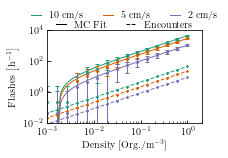

In [25]:
# Creating plots
densities = {}
plot_data = {}
flash_dens = {}
fit_lin = {}
fit_poly = {}
colors = ['#1b9e77', '#d95f02', '#7570b3']
for model in water_models:
    loaded_data = pickle.load(open("../data/storage/density_data_" + model[4] + '.p', "rb"))
    densities[model[4]] = loaded_data[0]
    plot_data[model[4]] = loaded_data[1]
    flash_dens[model[4]] = loaded_data[2]
    z1 = np.polyfit(densities[model[4]], plot_data[model[4]], 1, w=1./(flash_dens[model[4]]+1.))
    print(z1)
    z2 = np.polyfit(densities[model[4]], plot_data[model[4]], 3)
    fit_lin[model[4]] = np.poly1d(z1)
    fit_poly[model[4]] = np.poly1d(z2)
# ---------------------------------------------------------------------------------------------------
# Plotting

# Plotting standards
std_size = 3.
fontsize = 10.
lw=1.
h_length=1.
export_dpi = 500  # Dpi for the image export
# Plot figure with subplots of different sizes
fig, ax1 = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------------------------------------------------------------
# Plot parameters
ylow = 1e-3
yhigh = 0.2
# xlow = 0
# xhigh = 10
# ---------------------------------------------------------------------------------------------------
# The average emissions
for id_model, model in enumerate(water_models):
    ax1.errorbar(
        densities[model[4]],
        plot_data[model[4]],
        yerr=np.sqrt(plot_data[model[4]])*5.,
        linestyle="None", marker='o', markersize=2, elinewidth=1, capsize=2., color=colors[id_model])
    ax1.plot(np.logspace(-4, 0, 100), fit_lin[model[4]](np.logspace(-4, 0, 100)),
             lw=lw, ls='-', color=colors[id_model], label=model[3])
    ax1.plot(np.logspace(-4, 0, 100),
             priede_function(0.15, 0.05, model[1], np.logspace(-4, 0, 100)) * 60. * 60.,
             lw=lw, ls='--', color=colors[id_model])
    ax1.errorbar(densities[model[4]],
             priede_function(0.15, 0.05, model[1], densities[model[4]]) * 60. * 60.,
             yerr=priede_function(0.15, 0.05, model[1], densities[model[4]]) * 60. * 60. * 0.1,
             lw=lw, ls='', color=colors[id_model], marker='*', markersize=2)
    # ax1.plot(np.logspace(-4, 0, 100), fit_poly[model[4]](np.logspace(-4, 0, 100)),
    #          lw=lw, ls='-', color=colors[id_model])
# ax1.scatter(data_priede[:, 0], data_priede[:, 1], color='k')
# ---------------------------------------------------------------------------------------------------
ax1.set_xlabel(r'$\mathrm{Density\; [Org. / m^{-3}]}$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Flashes}\;\left[\mathrm{h}^{-1}\right]$', fontsize=fontsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.set_xlim(1e-3, 2e0)
ax1.set_ylim(1e-2, 1e4)
# --------------------------------------------------------------------------------------------------
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-', label=r'$\mathrm{MC\;Fit}$'),
                Line2D([0], [0], color='k', lw=1, ls='--', label=r'$\mathrm{Encounters}$')]
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:3],l[:3], loc=9, bbox_to_anchor=(0.5, +1.3),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
lgd2 = ax1.legend(custom_lines, [r'$\mathrm{MC\;Fit}$', r'$\mathrm{Encounters}$'],
                  loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------------------------------------------------------------
# General
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
fig.savefig(PICS + "MC_Peak_Count_Average.png",
            bbox_inches='tight', dpi=export_dpi)